In [1]:
from Data import Data
import dataset_prep_functions as data_prep
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt

## 1. Reading Data of Stock

In [2]:
data = Data('MSFT', '2009-01-01')

read unprocessed data


In [3]:
data.data_frame.head(3)

,price,volume,s&p500,ebit,total current assets,total current liabilities,net cash from total operating activities,gdp [USA],interest_rates [USA],unemployment [USA],inflation [USA]
2009-01-02,15.87,50084000.00,931.80,5187.09,38580.15,23742.09,10868.20,14394.08,0.25,12085.10,-0.35
2009-01-03,15.92,53881066.67,930.35,5167.48,38617.11,23743.48,10942.81,14393.62,0.25,12112.19,-0.34
2009-01-04,15.96,57678133.33,928.90,5147.88,38654.07,23744.88,11017.43,14393.16,0.25,12139.29,-0.34


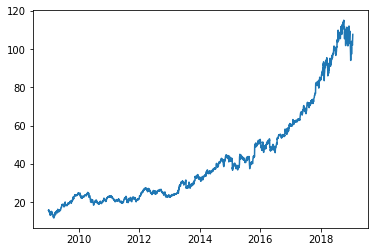

In [4]:
plt.plot(data.data_frame['price'])

## 2. Prepairing Data

In [5]:
normalized_df, price_scaler = data_prep.normalize(data.data_frame)
normalized_df.tail(5)

,price,volume,s&p500,ebit,total current assets,total current liabilities,net cash from total operating activities,gdp [USA],interest_rates [USA],unemployment [USA],inflation [USA]
2019-01-14,0.9469,0.3570,0.9137,0.985,0.9779,0.79,0.5772,1.0,2.4,0.0533,2.13
2019-01-15,0.9595,0.3849,0.9210,0.985,0.9779,0.79,0.5772,1.0,2.4,0.0533,2.13
2019-01-16,0.9611,0.3699,0.9225,0.985,0.9779,0.79,0.5772,1.0,2.4,0.0533,2.13
2019-01-17,0.9642,0.3566,0.9277,0.985,0.9779,0.79,0.5772,1.0,2.4,0.0533,2.13
2019-01-18,0.9707,0.4291,0.9366,0.985,0.9779,0.79,0.5772,1.0,2.4,0.0533,2.13


In [6]:
subseq_len = 100  # length of sequences fed into rnn
horizon = 50  # number of days predicted into future
validation_ratio = 0.10 # percent of validation data

In [7]:
# data sequences for later prediction test 
test_data_sequences = data_prep.get_subsequences(normalized_df.values, subseq_len, False)
fake_labels = np.zeros((test_data_sequences.shape[0], test_data_sequences.shape[1], horizon), dtype=np.float32)
test_data_sequences.shape, fake_labels.shape

((36, 100, 11), (36, 100, 50))

In [8]:
# split data into features x and labels y
x, y = data_prep.create_labels(normalized_df, horizon)
x.shape, y.shape

((3617, 11), (3617, 50))

In [9]:
# get overlapping subsequences of length subseq_len for features and labels
x_seq, y_seq = data_prep.get_subsequences(x, subseq_len), data_prep.get_subsequences(y,subseq_len)
x_seq.shape, y_seq.shape

((3517, 100, 11), (3517, 100, 50))

In [10]:
# shuffle, since the subsequences are considered indepedent and
# we want to have our validation data randomly distributed over the whole time period
c = np.concatenate((x_seq,y_seq), axis=2)
#np.random.shuffle(c)
c.shape

(3517, 100, 61)

In [11]:
# split data into training and validation data based on chosen validation_ratio 
train, valid = data_prep.split(c, validation_ratio)

x_train, x_valid = train[:,:,:-horizon], valid[:,:,:-horizon]
y_train, y_valid = train[:,:,-horizon:], valid[:,:,-horizon:]

(x_train.shape, x_valid.shape), (y_train.shape, y_valid.shape)

(((3166, 100, 11), (351, 100, 11)), ((3166, 100, 50), (351, 100, 50)))

## 3. Creating Dataset

In [12]:
tf.reset_default_graph()

# create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_sequences, fake_labels))

# shuffle training and validation datasets
train_dataset = train_dataset.shuffle(buffer_size=1000000)
valid_dataset = valid_dataset.shuffle(buffer_size=1000000)

# set batch sizes
batch_size = 1
train_dataset = train_dataset.batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# generate iterator and initializers for the datasets
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,train_dataset.output_shapes)
training_init_op = iterator.make_initializer(train_dataset)
valid_init_op = iterator.make_initializer(valid_dataset)
test_init_op = iterator.make_initializer(test_dataset)

next_batch = iterator.get_next()
input_seq, labels = next_batch[0], next_batch[1]

In [13]:
input_seq

<tf.Tensor 'IteratorGetNext:0' shape=(?, 100, 11) dtype=float32>

## 4. Computation Graph Definition

In [14]:
input_size = 11
lstm_size = 128
output_size = horizon

h_init = tf.placeholder(shape=[None,lstm_size], dtype=tf.float32)
c_init = tf.placeholder(shape=[None,lstm_size], dtype=tf.float32)

In [15]:
with tf.variable_scope("LSTM", reuse=tf.AUTO_REUSE) as scope:
    # Initialize list to save the hidden states and outputs of the sequence.
    hs = []
    
    # Initialize all weights and biases.
    initializer = tf.random_normal_initializer(stddev=0.125)
    
    # forget gate
    Wxf = tf.get_variable("Wxf", [input_size, lstm_size], initializer=initializer)
    Whf = tf.get_variable("Whf", [lstm_size, lstm_size], initializer=initializer)
    bf = tf.get_variable("bf", [lstm_size], initializer=initializer)
    
    # new candidate
    Wxc = tf.get_variable("Wxc", [input_size, lstm_size], initializer=initializer)
    Whc = tf.get_variable("Whc", [lstm_size, lstm_size], initializer=initializer)
    bc = tf.get_variable("bc", [lstm_size], initializer=initializer)
    
    # input gate
    Wxi = tf.get_variable("Wxi", [input_size, lstm_size], initializer=initializer)
    Whi = tf.get_variable("Whi", [lstm_size, lstm_size], initializer=initializer)
    bi = tf.get_variable("bi", [lstm_size], initializer=initializer)
    
    # output gate
    Wxo = tf.get_variable("Wxo", [input_size, lstm_size], initializer=initializer)
    Who = tf.get_variable("Who", [lstm_size, lstm_size], initializer=initializer)
    bo = tf.get_variable("bo", [lstm_size], initializer=initializer)
        
    # readout
    Why = tf.get_variable("Why", [lstm_size,output_size], initializer=initializer)
    by = tf.get_variable("by", [output_size], initializer=initializer)
    
    # Initialize the hidden and the cell state.
    h_t = h_init
    c_t = c_init


    for t in range(subseq_len):

        # Read out the ith input 
        x_t = input_seq[:, t]

        # forget gate
        f_t = tf.sigmoid(tf.matmul(x_t, Wxf) + tf.matmul(h_t, Whf) + bf)

        # input gate
        c_new_t = tf.sigmoid(tf.matmul(x_t, Wxc) + tf.matmul(h_t, Whc) + bc)
        i_t = tf.sigmoid(tf.matmul(x_t, Wxi) + tf.matmul(h_t, Whi) + bi)

        # update cell state
        c_t = f_t * c_t + i_t * c_new_t

        # output_gate
        h_new_t = tf.sigmoid(c_t)
        o_t = tf.sigmoid(tf.matmul(x_t, Wxo) + tf.matmul(h_t, Who) + bo)

        # update hidden state
        h_t = o_t * h_new_t




        # save hidden state
        hs.append(h_t)
    
    logits = []
    
    for h in hs:
        
        logits.append(tf.matmul(h, Why) + by)
    
    logits_tensor = logits[-1]

## 5. Definition of Metrics and Training Config

In [16]:
with tf.variable_scope("metrics", reuse=tf.AUTO_REUSE) as scope:    
    loss = tf.losses.mean_squared_error(predictions=logits, labels=labels)

with tf.variable_scope("optimizer", reuse=tf.AUTO_REUSE) as scope:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.1e-4)
    training_step = optimizer.minimize(loss)

In [17]:
tf.summary.scalar('loss', loss)
merged_summaries = tf.summary.merge_all()
train_writer = tf.summary.FileWriter("./summaries/train", tf.get_default_graph())
validation_writer = tf.summary.FileWriter("./summaries/validation", tf.get_default_graph())


## 6. Training, Validation, Prediction

In [18]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    step = 0
    
    for epoch in range(10):
    
        
        
        # Load the dataset into the iterator.
        sess.run(training_init_op)
        
        hs_feed_val = np.zeros([batch_size,lstm_size])
        cs_feed_val = np.zeros([batch_size,lstm_size])
                
        # Go through the dataset until it's empty.
        while True:
            try:
                               
                hs_feed_val, cs_feed_val, summaries, _ = \
                                sess.run([h_t,c_t, merged_summaries, training_step], 
                                        feed_dict={h_init: hs_feed_val,
                                                   c_init: cs_feed_val})
                
                train_writer.add_summary(summaries, global_step = step)

                step += 1
               

            # Stop if iterator is empty.
            except tf.errors.OutOfRangeError:
                break
          
        
        
        # validation after each epoch random over whole period
        sess.run(valid_init_op)
        
        hs_feed_val = np.zeros([batch_size,lstm_size])
        cs_feed_val = np.zeros([batch_size,lstm_size])
        
        while True:
            try:            
                
                hs_feed_val, cs_feed_val, summaries = \
                                sess.run([h_t,c_t, merged_summaries], 
                                        feed_dict={h_init: hs_feed_val,
                                                   c_init: cs_feed_val})
                
                validation_writer.add_summary(summaries, global_step = step)
                step += 1
               

            # Stop if iterator is empty.
            except tf.errors.OutOfRangeError:
                break

    sess.run(test_init_op)
    hs_feed_val = np.zeros([batch_size,lstm_size])
    cs_feed_val = np.zeros([batch_size,lstm_size])
    
    predictions = []
    while True:
        try:            

            hs_feed_val, cs_feed_val, logits = \
                            sess.run([h_t,c_t, logits_tensor], 
                                    feed_dict={h_init: hs_feed_val,
                                               c_init: cs_feed_val})

            predictions.append(logits)
        # Stop if iterator is empty.
        except tf.errors.OutOfRangeError:
            break

## 7. Evaluation and Visualization of predictions

In [25]:
predictions = np.squeeze(np.asarray(predictions))
pred_prices = [np.exp(price_scaler.inverse_transform([pred]))[0] for pred in predictions]
pred_prices = [scipy.ndimage.filters.gaussian_filter1d(price, sigma=7) for price in pred_prices]
dates = data_prep.get_subsequences(data.data_frame.index, n=subseq_len, overlapping=False, data_type=np.datetime64)[:,-1]
pred_dates = [pd.date_range(start=date, periods=horizon+1, closed='right') for date in dates]
pred_series = [pd.Series(prices, index=pred_date) for prices,pred_date in list(zip(pred_prices, pred_dates))]

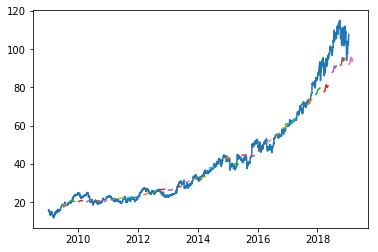

In [26]:
plt.plot(data.data_frame['price'])
for c, series in enumerate(pred_series):
    #if c%3 == (predictions.shape[0]-1)%10:
    plt.plot(series)
    
plt.show()

with tf.variable_scope("LSTM", reuse=tf.AUTO_REUSE) as scope:
    # placeholder for batch
    x = tf.placeholder(tf.float32, shape=(None, subseq_len, x_train.shape[-1]))
    
    lstm_sizes = [128,64]
    
    # Initialize weights and biases
    initializer = tf.random_normal_initializer(stddev=0.125)
    Why = tf.get_variable("Why", [lstm_sizes[-1],horizon], initializer=initializer)
    by = tf.get_variable("by", [horizon], initializer=initializer)
    
    # RNN
    rnn_cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.LSTMCell(size) for size in lstm_sizes])
    
    output, state = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32)
    output = tf.squeeze(output)